In [62]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import scipy

# Set random seed for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)


# Load the CSV files
posi_train_df = pd.read_csv('posi_train.csv')
negi_train_df = pd.read_csv('negi_train.csv')
posi_test_df = pd.read_csv('posi_test.csv')
negi_test_df = pd.read_csv('negi_test.csv')

# Add label column to dataframes
posi_train_df['COVID19'] = 1
negi_train_df['COVID19'] = 0
posi_test_df['COVID19'] = 1
negi_test_df['COVID19'] = 0

# Combine the positive and negative training data into one DataFrame
train_df = pd.concat([posi_train_df, negi_train_df], axis=0, ignore_index=True)

# Combine the positive and negative testing data into one DataFrame
test_df = pd.concat([posi_test_df, negi_test_df], axis=0, ignore_index=True)

# Define a function for feature extraction
def feature_extraction(data):
    # Extract the required columns from the data
    temp = data['temp'].to_numpy()
    pulse = data['pulse'].to_numpy()
    stats = data['stats'].to_numpy()
    
    # Add new features extracted from the existing ones
    mean = np.mean([temp, pulse, stats], axis=0)
    minimum = np.min([temp, pulse, stats], axis=0)
    maximum = np.max([temp, pulse, stats], axis=0)
    rms = np.sqrt(np.mean(np.square([temp, pulse, stats]), axis=0))
    std = np.std([temp, pulse, stats], axis=0)
    skew = scipy.stats.skew([temp, pulse, stats], axis=0)
    
    # Concatenate the extracted features
    features = np.concatenate([mean.reshape(-1, 1), minimum.reshape(-1, 1), maximum.reshape(-1, 1),
                               rms.reshape(-1, 1), std.reshape(-1, 1), skew.reshape(-1, 1)],
                              axis=1)
    
    # Return the extracted features as a numpy array
    return features

# Preprocess the data
X_train = feature_extraction(train_df)
Y_train = train_df['COVID19'].to_numpy()

X_test = feature_extraction(test_df)
Y_test = test_df['COVID19'].to_numpy()

# Flatten the input data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Convert the labels to one-hot encoding
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.00001)),
    tf.keras.layers.Dense(Y_train.shape[1], activation='softmax', name='y_pred')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val))

# Print the training and validation accuracy
train_loss, train_acc = model.evaluate(X_train, Y_train)
val_loss, val_acc = model.evaluate(X_val, Y_val)
print('Training accuracy:', train_acc)
print('Validation accuracy:', val_acc)


Epoch 1/20
42/42 [==============================] - 1s 7ms/step - loss: 2.1352 - accuracy: 0.5060 - val_loss: 1.3053 - val_accuracy: 0.5269
Epoch 2/20
42/42 [==============================] - 0s 3ms/step - loss: 1.0028 - accuracy: 0.5352 - val_loss: 0.9123 - val_accuracy: 0.4671
Epoch 3/20
42/42 [==============================] - 0s 3ms/step - loss: 0.8474 - accuracy: 0.7552 - val_loss: 0.7783 - val_accuracy: 0.9431
Epoch 4/20
42/42 [==============================] - 0s 3ms/step - loss: 0.7643 - accuracy: 0.8915 - val_loss: 0.7562 - val_accuracy: 0.7725
Epoch 5/20
42/42 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.8930 - val_loss: 0.6752 - val_accuracy: 0.8204
Epoch 6/20
42/42 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.9424 - val_loss: 0.5992 - val_accuracy: 0.9671
Epoch 7/20
42/42 [==============================] - 0s 3ms/step - loss: 0.6089 - accuracy: 0.9543 - val_loss: 0.5585 - val_accuracy: 0.9731
Epoch 8/20
42/42 [==

In [63]:
# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

14/14 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.9952
Test accuracy: 0.9952380657196045


14/14 [==============================] - 0s 2ms/step
Training accuracy: 95.13%
Testing accuracy: 99.52%
Classification report for training data:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       677
           1       1.00      0.90      0.95       659

    accuracy                           0.95      1336
   macro avg       0.96      0.95      0.95      1336
weighted avg       0.96      0.95      0.95      1336

Classification report for testing data:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       210
           1       0.99      1.00      1.00       210

    accuracy                           1.00       420
   macro avg       1.00      1.00      1.00       420
weighted avg       1.00      1.00      1.00       420



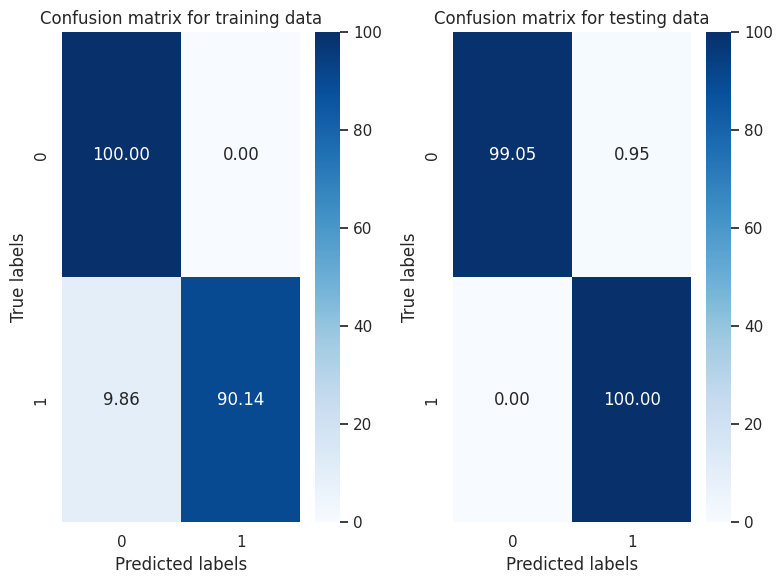

In [64]:
from sklearn.metrics import classification_report, accuracy_score

# Get the predicted classes for training and testing data
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Convert the predicted classes to binary format
Y_train_pred_binary = np.argmax(Y_train_pred, axis=1)
Y_test_pred_binary = np.argmax(Y_test_pred, axis=1)

# Generate the confusion matrix for training data
cm_train = confusion_matrix(Y_train.argmax(axis=1), Y_train_pred_binary)
cm_train_percent = cm_train / cm_train.sum(axis=1)[:, np.newaxis] * 100

# Generate the confusion matrix for testing data
cm_test = confusion_matrix(Y_test.argmax(axis=1), Y_test_pred_binary)
cm_test_percent = cm_test / cm_test.sum(axis=1)[:, np.newaxis] * 100

# Calculate the accuracy score for training and testing data
acc_train = accuracy_score(Y_train.argmax(axis=1), Y_train_pred_binary)
acc_test = accuracy_score(Y_test.argmax(axis=1), Y_test_pred_binary)

# Generate the classification report for training and testing data
cr_train = classification_report(Y_train.argmax(axis=1), Y_train_pred_binary)
cr_test = classification_report(Y_test.argmax(axis=1), Y_test_pred_binary)

# Print the accuracy scores and classification reports for training and testing data
print("Training accuracy: {:.2f}%".format(acc_train * 100))
print("Testing accuracy: {:.2f}%".format(acc_test * 100))
print("Classification report for training data:\n", cr_train)
print("Classification report for testing data:\n", cr_test)

# Plot the confusion matrices
sns.set(font_scale=1)
plt.figure(figsize=(8, 6))

plt.subplot(121)
sns.heatmap(cm_train_percent, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix for training data')

plt.subplot(122)
sns.heatmap(cm_test_percent, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix for testing data')

plt.tight_layout()
plt.show()


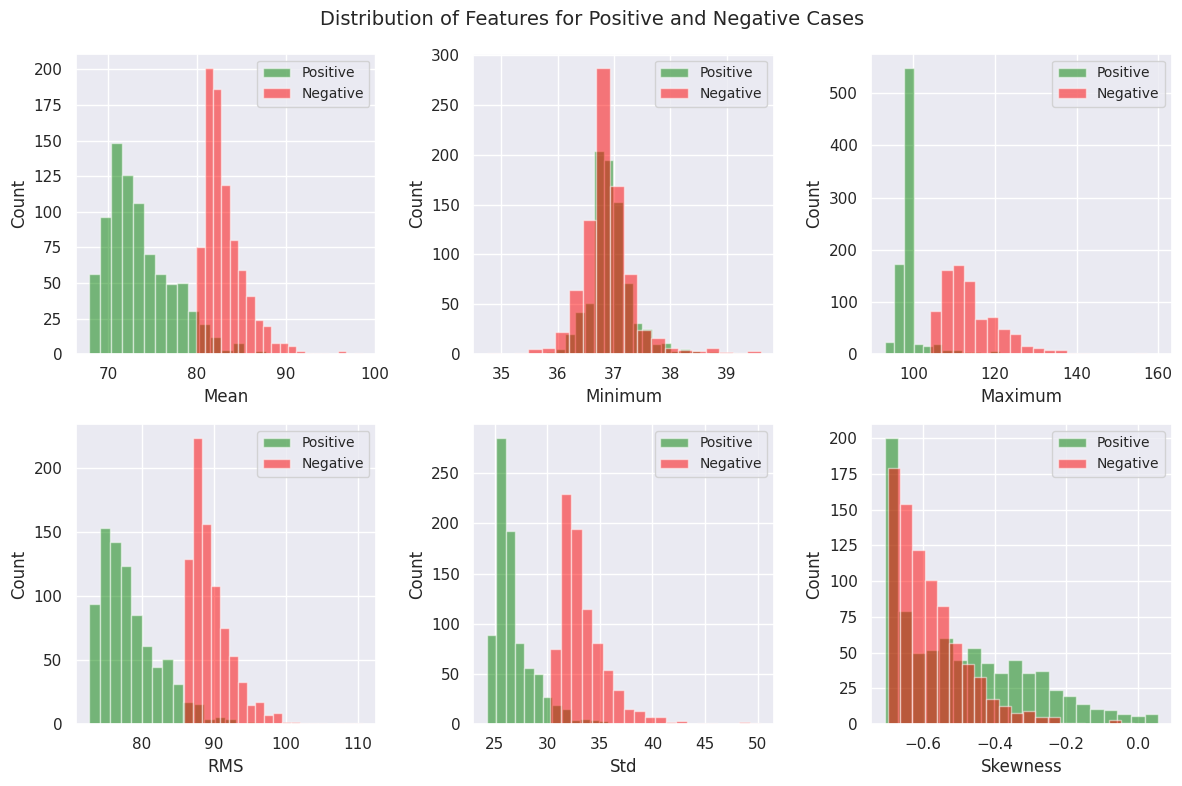

In [65]:
# Define feature names
feature_names = ['Mean', 'Minimum', 'Maximum', 'RMS', 'Std', 'Skewness']

# Extract features for positive and negative cases
positive_features = feature_extraction(posi_train_df)
negative_features = feature_extraction(negi_train_df)

# Create subplots for each feature
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Set a common title for the subplots
fig.suptitle('Distribution of Features for Positive and Negative Cases', fontsize=14)

# Plot the distributions of the features
for i, feature in enumerate(feature_names):
    row = i // 3
    col = i % 3
    axs[row, col].hist(positive_features[:, i], bins=20, alpha=0.5, label='Positive', color='green')
    axs[row, col].hist(negative_features[:, i], bins=20, alpha=0.5, label='Negative', color='red')
    axs[row, col].set_xlabel(feature, fontsize=12)
    axs[row, col].set_ylabel('Count', fontsize=12)
    axs[row, col].legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()


In [69]:
# Interpretation of the results
print("Interpretation of the results:")
for i, feature in enumerate(feature_names):
    pos_mean = np.mean(positive_features[:, i])
    neg_mean = np.mean(negative_features[:, i])
    pos_std = np.std(positive_features[:, i])
    neg_std = np.std(negative_features[:, i])
    print(f"Feature '{feature}':")
    print(f"\t- Mean (Positive): {pos_mean:.3f}")
    print(f"\t- Mean (Negative): {neg_mean:.3f}")
    print(f"\t- Standard Deviation (Positive): {pos_std:.3f}")
    print(f"\t- Standard Deviation (Negative): {neg_std:.3f}")
    print()


Interpretation of the results:
Feature 'Mean':
	- Mean (Positive): 73.585
	- Mean (Negative): 83.153
	- Standard Deviation (Positive): 3.676
	- Standard Deviation (Negative): 2.410

Feature 'Minimum':
	- Mean (Positive): 36.938
	- Mean (Negative): 36.877
	- Standard Deviation (Positive): 0.382
	- Standard Deviation (Negative): 0.476

Feature 'Maximum':
	- Mean (Positive): 99.376
	- Mean (Negative): 114.152
	- Standard Deviation (Positive): 4.053
	- Standard Deviation (Negative): 7.487

Feature 'RMS':
	- Mean (Positive): 78.343
	- Mean (Negative): 89.644
	- Standard Deviation (Positive): 4.135
	- Standard Deviation (Negative): 3.133

Feature 'Std':
	- Mean (Positive): 26.875
	- Mean (Negative): 33.464
	- Standard Deviation (Positive): 2.063
	- Standard Deviation (Negative): 2.383

Feature 'Skewness':
	- Mean (Positive): -0.492
	- Mean (Negative): -0.580
	- Standard Deviation (Positive): 0.188
	- Standard Deviation (Negative): 0.103



In [67]:
model.save('model.h5')